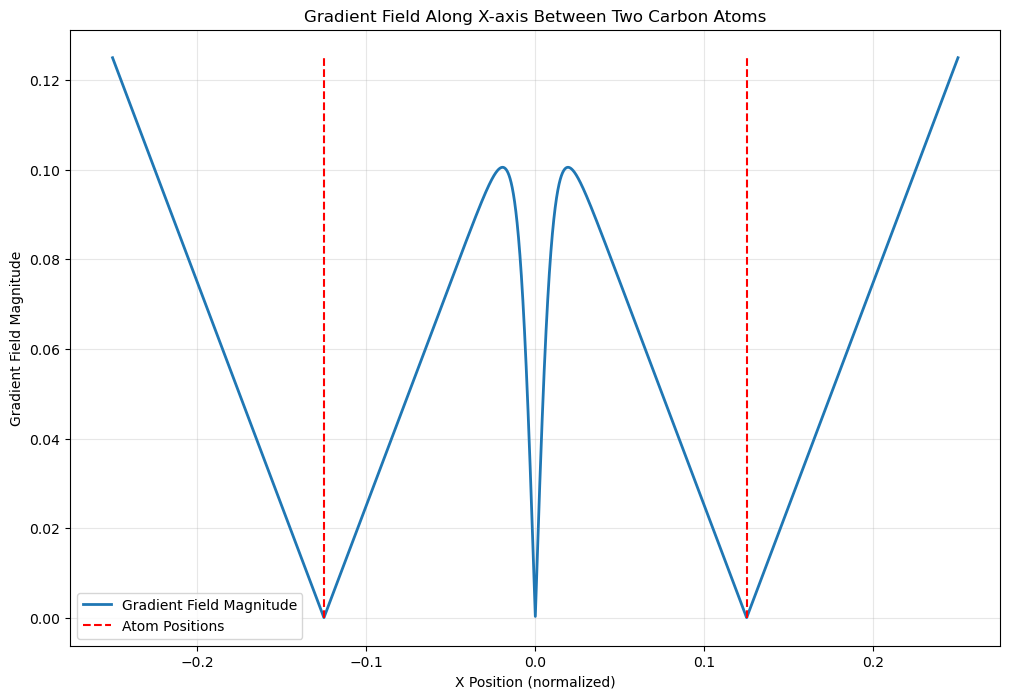

Atom positions: tensor([[-0.1250,  0.0000,  0.0000],
        [ 0.1250,  0.0000,  0.0000]])
Atom types: tensor([0, 0])
Converter parameters:
  - sigma: 1
  - temperature: 0.01
  - gradient_field_method: softmax
  - sigma_ratios: {'C': 0.9, 'H': 1.3, 'O': 1.1, 'N': 1.0, 'F': 1.2}


In [10]:
import torch
import matplotlib.pyplot as plt
import os
import hydra
import sys
from pathlib import Path

project_root = Path(os.getcwd()).parent
sys.path.insert(0, str(project_root))
from funcmol.dataset.dataset_field import create_gnf_converter

# 采样、创建原子坐标
# 按照1.5A的碳碳键距离，创建两个原子
# 由于grid_dim: 48，resolution: .25，所以缩放比例是1/6
# 那么缩放后的原子距离为1.5/6=0.25
x = torch.linspace(-0.25, 0.25, 10000)
atoms = torch.tensor([[-0.125, 0, 0], [0.125, 0, 0]])

# 创建原子类型
atom_types = torch.zeros(len(atoms), dtype=torch.long)

# 加载配置
config_dir = str(Path.cwd().parent / "configs")
with hydra.initialize_config_dir(config_dir=config_dir, version_base=None):
    config = hydra.compose(config_name="train_nf_qm9")

# 创建GNFConverter实例
converter = create_gnf_converter(config, device="cpu")
converter.temperature = 0.01

# 创建图形
plt.figure(figsize=(12, 8))

# 计算梯度场
grad_list = []
for x_this in x:
    query_point = torch.zeros(3)
    query_point[0] = x_this
    # 修复：正确的维度 [1, 1, 3]
    grad = converter.mol2gnf(atoms.unsqueeze(0), atom_types.unsqueeze(0), query_point.unsqueeze(0).unsqueeze(0))
    # 计算梯度场的3D范数
    grad_norm = torch.norm(grad[0, 0, 0, :], dim=0).item()  # 取碳原子类型(0)的梯度场范数
    grad_list.append(grad_norm)

# 绘制梯度场和原子位置
plt.plot(x, grad_list, label='Gradient Field Magnitude', linewidth=2)
plt.vlines([-0.125, 0.125], 0, max(grad_list), colors='red', linestyles='--', label='Atom Positions')
plt.xlabel('X Position (normalized)')
plt.ylabel('Gradient Field Magnitude')
plt.title('Gradient Field Along X-axis Between Two Carbon Atoms')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 打印一些调试信息
print(f"Atom positions: {atoms}")
print(f"Atom types: {atom_types}")
print(f"Converter parameters:")
print(f"  - sigma: {converter.sigma}")
print(f"  - temperature: {converter.temperature}")
print(f"  - gradient_field_method: {converter.gradient_field_method}")
print(f"  - sigma_ratios: {converter.sigma_ratios}")